In [1]:
# import needed libraries
import quandl
import pandas as pd
import os
import datetime
import numpy as np
import math
import re
import seaborn as sns
import mplfinance as mpf
import matplotlib.ticker as mticker
import requests

quandl.ApiConfig.api_key = '4FM6nPGJT-5Hye2T4g3y'

In [2]:
date_format = '%Y-%m-%d'

def get_date(string):
    return datetime.datetime.strptime(string, date_format)


def within_n_days(date, days):
    n_days_ago = datetime.datetime.now() - datetime.timedelta(days = days)
    return date >= n_days_ago


def quandl_format(df):
    df = df.drop(["Open", "High", "Low", "Close", "Volume", "Dividend", "Split"], axis = 1)
    df = df.rename(columns={"Adj_Open": "Open", "Adj_High": "High", "Adj_Low": "Low", "Adj_Close": "Close", "Adj_Volume": "Volume"})
    return df


def get_quandl_range(ticker, start, end):
    return quandl.get(f'EOD/{ticker}',
                      start_date = start.strftime(date_format),
                      end_date = end.strftime(date_format),
                      paginate=True)


def get_quandl(ticker, days_lookback):
    end = datetime.datetime.now()
    start = end - datetime.timedelta(days = days_lookback)
    
    return quandl_format(get_quandl_range(ticker, start, end))


def quandl_download_ticker(ticker, days_lookback, overwrite = True):
    stock_data_dir = 'stock_data'
    if not os.path.exists(stock_data_dir):
        os.mkdir(stock_data_dir)
    try:
        path_ticker = re.sub(r"^PRN$", "PRN_", ticker)
        path = os.path.realpath(f"{stock_data_dir}/{path_ticker}.pk")
        if not overwrite and os.path.exists(path):
            return
        
        data = get_quandl(ticker, days_lookback)
        
        data.to_pickle(path)
    except Exception as e:
        print(f" Error Occured when attempting to download {ticker}.")
        print(e)


def quandl_load_ticker(ticker):
    ticker = ticker.replace(".", "_")
    ticker = re.sub(r"^PRN$", "PRN_", ticker)
    return pd.read_pickle(f"stock_data/{ticker}.pk")


def quandl_load_tickers(tickers_path = "quandl_ticker_list.csv"):
    r = requests.get("https://s3.amazonaws.com/quandl-production-static/end_of_day_us_stocks/ticker_list.csv")
    with open(tickers_path, 'wb+') as f:
        f.write(r.content)
    return pd.read_csv(tickers_path)


def quandl_download_all_tickers(days_lookback):
    all_tickers = quandl_load_tickers()

    # Format types
    all_tickers["Last Trade Date"] = all_tickers["Last Trade Date"].transform(lambda x: get_date(x))
    active_tickers = all_tickers[all_tickers['Last Trade Date'].apply(lambda x: within_n_days(x, 10))]
    
    print("Total Tickers: " + str(all_tickers["Ticker"].count()))
    print("Active Tickers: " + str(active_tickers["Ticker"].count()))

    for i, row in enumerate(active_tickers.iterrows()):
        if i % 100 == 0 or i == 1:
            print(f"{i} equities downloaded...")
        t = row[1]["Ticker"].replace(".", "_")
        quandl_download_ticker(t, days_lookback, overwrite = False)


In [3]:
quandl_download_ticker("TSLA", 1000)
tsla = quandl_load_ticker("TSLA")

In [4]:
tsla.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-05-24,55.68000,56.222,54.978,55.570,20883540.0
2018-05-25,55.52504,55.928,55.122,55.770,19375410.0
2018-05-29,55.70200,57.300,55.230,56.752,28333200.0
2018-05-30,56.65800,59.001,56.320,58.344,37448430.0
2018-05-31,57.44200,58.074,56.586,56.946,29598605.0


In [5]:
closing_prices = [date[3] for date in tsla.values.tolist()][0:359]

In [6]:
from ipynb.fs.full.time_domain_filter import *

In [30]:
from math import cos, sin, pi
K = 1 # test with only single pole for now
cutoff = 10

In [8]:
decycler = TimeDomainFilter(K,cutoff)
decycler_output = decycler.decycle(closing_prices, 'decycler')

1.096540954083931


In [9]:
import matplotlib

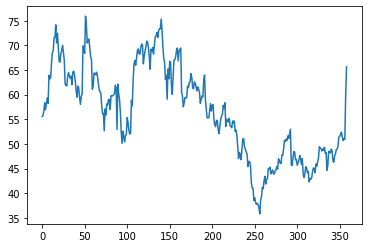

In [10]:
matplotlib.pyplot.plot(closing_prices) # original tesla closing prices

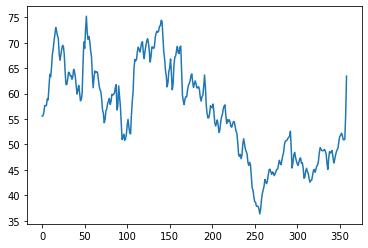

In [11]:
matplotlib.pyplot.plot(decycler_output) # decycled

0.46814750868361577
0.2599526287558494


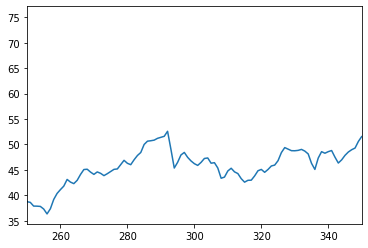

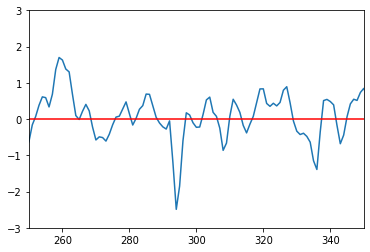

In [34]:
hp1 = TimeDomainFilter(0.707,10)
hp1_output = hp1.high_pass_filter(closing_prices, 'HPF-2pole')
hp2 = TimeDomainFilter(0.707,20)
hp2_output = hp2.high_pass_filter(closing_prices, 'HPF-2pole')

decycler_osc_output = hp2_output - hp1_output
matplotlib.pyplot.figure(0)
matplotlib.pyplot.plot(decycler_output)
matplotlib.pyplot.xlim(250, 350) 
matplotlib.pyplot.figure(1)
matplotlib.pyplot.plot(decycler_osc_output)
matplotlib.pyplot.ylim(-3, 3) 
matplotlib.pyplot.xlim(250, 350) 

matplotlib.pyplot.axhline(y=0, color='r', linestyle='-')